<a href="https://colab.research.google.com/github/aimal1amiri/Hybrid-model/blob/master/hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
from pathlib import Path


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/MyDrive/dataset"
categories = os.listdir(dataset_dir)

print(categories)

['chicken_pox', 'cow_pox', 'healthy', 'HFMD', 'measles', 'monkey_pox']


In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:

def load_and_split_data(dataset_dir):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, file))
            labels.append(label)


    X_train, X_temp, y_train, y_temp = train_test_split(filepaths, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_dir)


In [ ]:

# Data Preprocessing
def preprocess_image(file_path):

    image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)

    image = tf.image.resize(image, IMG_SIZE)

    image = image / 255.0
    return image

In [ ]:
def create_generator(filepaths, labels, batch_size=BATCH_SIZE):
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(categories))
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:

train_generator = create_generator(X_train, y_train)
val_generator = create_generator(X_val, y_val)
test_generator = create_generator(X_test, y_test)


In [ ]:
from tensorflow.keras.applications import DenseNet121, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
# DenseNet121 Model
base_model1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x1 = GlobalAveragePooling2D()(base_model1.output)

# InceptionV3 Model
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x2 = GlobalAveragePooling2D()(base_model2.output)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### **When necessary features are extracted from the image by both models , then in this concatenatd layer , combines them then later they classify it that to which label is related.**

In [ ]:

combined_features = Concatenate()([x1, x2])


x = Dense(256, activation='relu')(combined_features)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)


model = Model(inputs=[base_model1.input, base_model2.input], outputs=output)


In [ ]:
for layer in base_model1.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True


for layer in base_model2.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Final-Version-Models-for-Mpox/best_hybrid_model_v3.keras", save_best_only=True, monitor='val_loss')


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
def prepare_two_inputs(generator):
    dataset = generator.map(lambda x, y: ((x, x), y))
    return dataset


In [ ]:
train_dataset = prepare_two_inputs(train_generator)
val_dataset = prepare_two_inputs(val_generator)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 759s 4s/step - accuracy: 0.5791 - loss: 1.1253 - val_accuracy: 0.9038 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.9562 - loss: 0.1394 - val_accuracy: 0.9501 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.9931 - loss: 0.0329 - val_accuracy: 0.9641 - val_loss: 0.1096 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 566ms/step - accuracy: 0.9983 - loss: 0.0105 - val_accuracy: 0.9641 - val_loss: 0.1194 - learning_rate: 1.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 564ms/step - accuracy: 0.9987 - loss: 0.0097 - val_accuracy: 0.9668 - val_loss: 0.1139 - learning_rate: 1.0000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9729 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 594m

In [ ]:
test_dataset = prepare_two_inputs(test_generator)


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9841 - loss: 0.0563
Test Accuracy: 0.98


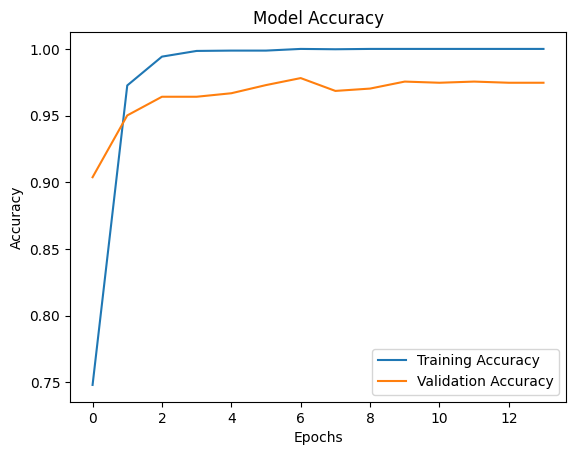

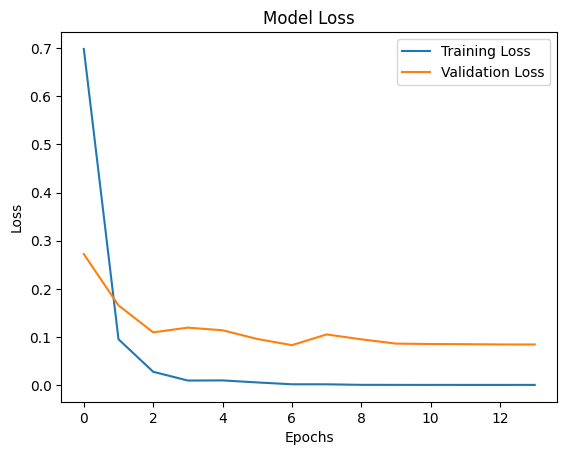

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def create_generator(filepaths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), tf.one_hot(y, depth=len(categories))))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
def create_fixed_generator(filepaths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), tf.one_hot(y, depth=len(categories))))
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (224, 224, 3)), y))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
test_dataset = create_fixed_generator(X_test, y_test, batch_size=32)


In [ ]:
for x, y in test_dataset.take(1):
    print(f"Fixed Input Shape: {tf.shape(x)}")  # Should be [32, 224, 224, 3]
    print(f"Fixed Label Shape: {tf.shape(y)}")  # Should be [32, num_classes]


Fixed Input Shape: [ 32 224 224   3]
Fixed Label Shape: [32  6]


In [ ]:
formatted_test_dataset = prepare_two_inputs(test_dataset)


In [ ]:
for (input1, input2), labels in formatted_test_dataset.take(1):
    print(f"Input1 Shape: {tf.shape(input1)}")  # Should be [32, 224, 224, 3]
    print(f"Input2 Shape: {tf.shape(input2)}")  # Should be [32, 224, 224, 3]
    print(f"Labels Shape: {tf.shape(labels)}")  # Should be [32, 6]


Input1 Shape: [ 32 224 224   3]
Input2 Shape: [ 32 224 224   3]
Labels Shape: [32  6]


In [ ]:
y_true = []
y_pred = []

# Predict on the test dataset
for (input1, input2), labels in formatted_test_dataset:
    predictions = model.predict([input1, input2])  # Provide two inputs to the model
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Append true class indices
    y_pred.extend(np.argmax(predictions, axis=1))  # Append predicted class indices


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


<Figure size 1000x800 with 0 Axes>

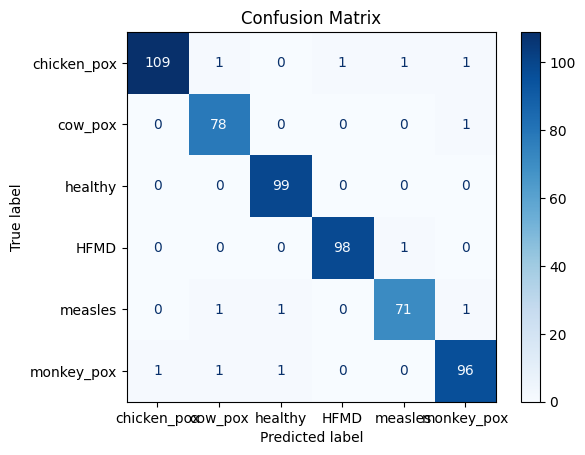

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()
